In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from tqdm import tqdm
import multiprocessing as mp
import bilby
import numpy as np
from pycbc.waveform import get_td_waveform, taper_timeseries
from gwmat import point_lens
import matplotlib.pyplot as plt
import gwmat
import os
import sys
from pycbc.detector.ground import Detector
import pycbc
import bilby

import corner
from modules.gw_utils import scale_signal
import torch
from torch.utils.data import Dataset, DataLoader

from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation

from modules.gw_utils import inject_noise_with_target_SNR

In [ ]:
num_samples = 5000
f_lower = 5.0       

priors = bilby.core.prior.PriorDict()

priors["mass1"] = bilby.core.prior.Constraint(name="mass1", minimum=10, maximum=100)
priors["mass2"] = bilby.core.prior.Constraint(name="mass2", minimum=10, maximum=100)
priors['mass_ratio'] = bilby.gw.prior.UniformInComponentsMassRatio(name='mass_ratio', minimum=0.2, maximum=1)
priors['chirp_mass'] = bilby.gw.prior.UniformInComponentsChirpMass(name='chirp_mass', minimum=25, maximum=100)
priors['spin1z'] = bilby.core.prior.Uniform(name='spin1z', minimum=0.0, maximum=0.9)
priors['spin2z'] = bilby.core.prior.Uniform(name='spin2z', minimum=0.0, maximum=0.9)
# priors['eccentricity'] = bilby.core.prior.Uniform(name='eccentricity', minimum=0.1, maximum=0.6)
# priors['coa_phase'] = bilby.core.prior.Uniform(name='coa_phase', minimum=0.0, maximum=2 * np.pi)
# priors['distance'] = bilby.core.prior.Uniform(name='distance', minimum=100, maximum=1000)
priors['dec'] = bilby.core.prior.Cosine(minimum=-np.pi/2, maximum=np.pi/2)
priors['ra'] = bilby.core.prior.Uniform(minimum=0., maximum=2*np.pi, boundary="periodic")
priors['polarization'] = bilby.core.prior.Uniform(minimum=0., maximum=np.pi, boundary="periodic")
priors['snr'] = bilby.core.prior.Uniform(minimum=10, maximum=100)

priors['Log_Mlz'] = bilby.core.prior.Uniform(minimum = 1, maximum = 5)
priors['yl'] = bilby.core.prior.PowerLaw(alpha = 1, minimum = 0.01, maximum = 1.0)

parameters_list = priors.sample(num_samples)

samples = [
    {key: parameters_list[key][i] for key in parameters_list}
    for i in range(num_samples)
]

print(f"Length of parameters_list: {len(samples)}")

21:18 bilby WARNING : Prior sampling efficiency is very low, please verify its validity.


Length of parameters_list: 5000


In [ ]:
def waveform(num):
    parameters = samples[num].copy()

    mass1, mass2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(parameters['chirp_mass'], parameters['mass_ratio'])

    m_lens = np.power(10., parameters["Log_Mlz"])
    y_lens = parameters["yl"]

    sp, sc = get_td_waveform(
        approximant='teobresums',
        mass1=mass1,
        mass2=mass2,
        lambda1=0,
        lambda2=0,
        spin1z=parameters['spin1z'],
        spin2z=parameters['spin2z'],
        distance=parameters['distance'],
        delta_t=1.0 / 4096 ,
        ecc=0,
        # coa_phase=parameters['coa_phase'],
        f_lower=5,
    )

    ####---------------------Generating Lensed Waveform--------------------####

    sp_freq = sp.to_frequencyseries(delta_f = sp.delta_f)
    sc_freq = sc.to_frequencyseries(delta_f = sc.delta_f)

    fs1 = sp_freq.sample_frequencies
    assert np.allclose(fs1, sc_freq.sample_frequencies), "Sample frequencies do not match!"

    Ffs_sp = np.vectorize(lambda f: gwmat.cythonized_point_lens.Ff_effective(f, ml=m_lens, y=y_lens))(fs1)
        
    time_Delay = point_lens.time_delay(ml=m_lens, y=y_lens)

    sp_lensed = pycbc.types.FrequencySeries(np.conj(Ffs_sp) * np.asarray(sp_freq), delta_f=sp_freq.delta_f).cyclic_time_shift(-1 * (0.1 + time_Delay))
    sc_lensed = pycbc.types.FrequencySeries(np.conj(Ffs_sp) * np.asarray(sc_freq), delta_f=sc_freq.delta_f).cyclic_time_shift(-1 * (0.1 + time_Delay))

    sp_lensed = sp_lensed.to_timeseries(delta_t=sp_lensed.delta_t)
    sc_lensed = sc_lensed.to_timeseries(delta_t=sc_lensed.delta_t)


    ####---------------------Projecting on detector--------------------####

    detector = Detector('H1')

    lensed_signal = detector.project_wave(sp_lensed, sc_lensed, ra = parameters['ra'], dec = parameters['dec'], polarization = parameters['polarization'])

    lensed_signal = taper_timeseries(lensed_signal, tapermethod="TAPER_STARTEND", return_lal=False)

    lensed_noisy, lensed_snr, distance = inject_noise_with_target_SNR(lensed_signal, num)

    lensed_noisy = lensed_noisy.crop(left=24, right=0)

    return np.array(lensed_noisy)

In [4]:
def simulator(num):
    return waveform(num), list(samples[num].values())

In [5]:
num_simulations = num_samples

def simulate_one(ii):
    y_val, theta_val = simulator(ii)
    return theta_val, y_val

In [6]:
num_simulations = num_samples

if __name__ == "__main__":
    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.map(simulate_one, range(num_simulations))


theta_vals, data_vals = zip(*results)

/home/qubit/miniconda3/envs/nn_1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: overflow encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


Scaling signal to achieve SNR of 14.13 for sample 181
Scaling signal to achieve SNR of 12.59 for sample 4
Scaling signal to achieve SNR of 19.33 for sample 768
Scaling signal to achieve SNR of 16.14 for sample 684
Scaling signal to achieve SNR of 13.64 for sample 885
Scaling signal to achieve SNR of 16.66 for sample 308
Scaling signal to achieve SNR of 16.89 for sample 799
Scaling signal to achieve SNR of 17.32 for sample 1719
Scaling signal to achieve SNR of 15.90 for sample 1898
Scaling signal to achieve SNR of 11.10 for sample 1690
Scaling signal to achieve SNR of 18.10 for sample 1513
Scaling signal to achieve SNR of 19.38 for sample 1559
Scaling signal to achieve SNR of 11.90 for sample 2223


/home/qubit/miniconda3/envs/nn_1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: overflow encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


Scaling signal to achieve SNR of 18.40 for sample 3396
Scaling signal to achieve SNR of 11.01 for sample 3665
Scaling signal to achieve SNR of 19.26 for sample 3917
Scaling signal to achieve SNR of 17.72 for sample 2959
Scaling signal to achieve SNR of 10.69 for sample 4600
Scaling signal to achieve SNR of 19.34 for sample 4863
Scaling signal to achieve SNR of 12.43 for sample 4023
Scaling signal to achieve SNR of 18.43 for sample 4025
Scaling signal to achieve SNR of 16.13 for sample 4035


/home/qubit/miniconda3/envs/nn_1/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: overflow encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


In [8]:
print(type(theta_vals[0]))
print(theta_vals[0])

<class 'list'>
[np.float64(0.2796113967195563), np.float64(65.38935225796904), np.float64(0.23567129588168031), np.float64(0.307068599260495), np.float64(242.1861833513825), np.float64(0.16810608115361247), np.float64(5.635428621235386), np.float64(1.2204234406658494), np.float64(2.9714419820988254), np.float64(0.3143563564311537)]


In [ ]:
import torch

torch.save({"waveforms": data_vals, "parameters": theta_vals}, "gw_lensed_dataset.pt")

# data = torch.load("gw_lensed_dataset.pt")
# waveforms = data["waveforms"]
# parameters = data["parameters"]


In [11]:
# convert to torch tensors
theta_vals = torch.from_numpy(np.array(theta_vals)).to(torch.float32)
data_vals = torch.from_numpy(np.array(data_vals)).to(torch.float32)

# create dataset
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return theta_vals[idx], data_vals[idx]

dataset = DataGenerator()

# create dataloaders - 80/10/10 split
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

train_data_loader = DataLoader(
    train_data, batch_size=256,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=256,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [12]:
len(train_data_loader), len(val_data_loader), len(test_data_loader)

(16, 2, 500)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
num_transforms = 24
num_blocks = 24
hidden_features = 50

context_features = data_vals[0].shape[0]
parameter_space_dim = len(samples[0].keys())

base_dist = StandardNormal([parameter_space_dim])  

transforms = []

for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
                features=parameter_space_dim, 
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks,
                activation=torch.tanh,
                use_batch_norm=True,
                use_residual_blocks=False,
        ),
        RandomPermutation(features=parameter_space_dim)
    ]
    transforms += block

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)

In [15]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [ ]:
best_val_loss = float('inf')
early_stopping_counter = 0
patience = 10  # stop if no improvement after 10 epochs

for epoch in range(500):
    flow.train()
    train_loss_total = 0.0

    train_loader = tqdm(train_data_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)
    for theta, data in train_loader:
        theta = theta.to(device)
        data = data.to(device)

        optimizer.zero_grad()
        loss = -flow.log_prob(theta, context=data).mean()
        loss.backward()
        optimizer.step()

        train_loss_total += loss.item()
        train_loader.set_postfix(loss=loss.item())

    scheduler.step()
    train_loss_avg = train_loss_total / len(train_data_loader)

    flow.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        val_loader = tqdm(val_data_loader, desc=f"Epoch {epoch+1} [Val]", leave=False)
        for theta, data in val_loader:
            theta = theta.to(device)
            data = data.to(device)

            val_loss = -flow.log_prob(theta, context=data).mean()
            val_loss_total += val_loss.item()
            val_loader.set_postfix(loss=val_loss.item())

    val_loss_avg = val_loss_total / len(val_data_loader)

    # Early stopping check
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        early_stopping_counter = 0  # reset counter
    else:
        early_stopping_counter += 1

    if early_stopping_counter > patience:
        print("Early stopping triggered! Training stopped.")
        break

    if epoch == 0 or (epoch+1) % 50 == 0:
        print(f"[Epoch {epoch+1}] Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f}")

[Epoch 1] Train Loss: 93.1441 | Val Loss: 88.4003


[Epoch 10] Train Loss: 25.8248 | Val Loss: 29.1975


[Epoch 20] Train Loss: 20.2517 | Val Loss: 21.9613


[Epoch 30] Train Loss: 18.9944 | Val Loss: 19.2546


[Epoch 40] Train Loss: 18.4329 | Val Loss: 22.8960


[Epoch 50] Train Loss: 18.1057 | Val Loss: 18.5968


[Epoch 60] Train Loss: 17.9287 | Val Loss: 18.6356


[Epoch 70] Train Loss: 17.7562 | Val Loss: 17.9174


[Epoch 80] Train Loss: 17.6884 | Val Loss: 17.8011


[Epoch 90] Train Loss: 17.6331 | Val Loss: 17.6968


[Epoch 100] Train Loss: 17.5905 | Val Loss: 17.7163


[Epoch 110] Train Loss: 17.6189 | Val Loss: 17.6669


[Epoch 120] Train Loss: 17.5522 | Val Loss: 17.6634


[Epoch 130] Train Loss: 17.5748 | Val Loss: 17.6373


[Epoch 140] Train Loss: 17.5426 | Val Loss: 17.6404


[Epoch 150] Train Loss: 17.5564 | Val Loss: 17.6516


[Epoch 160] Train Loss: 17.5494 | Val Loss: 17.6472


[Epoch 170] Train Loss: 17.5332 | Val Loss: 17.6368


[Epoch 180] Train Loss: 17.6099 | Val Loss: 17.6713


[Epoch 190] Train Loss: 17.5542 | Val Loss: 17.6458


[Epoch 200] Train Loss: 17.5804 | Val Loss: 17.6411


[Epoch 210] Train Loss: 17.5630 | Val Loss: 17.6361


[Epoch 220] Train Loss: 17.5476 | Val Loss: 17.6498


[Epoch 230] Train Loss: 17.5529 | Val Loss: 17.6362


[Epoch 240] Train Loss: 17.5442 | Val Loss: 17.6372


[Epoch 250] Train Loss: 17.5495 | Val Loss: 17.6255


[Epoch 260] Train Loss: 17.5606 | Val Loss: 17.6351


[Epoch 270] Train Loss: 17.5671 | Val Loss: 17.6425


[Epoch 280] Train Loss: 17.5669 | Val Loss: 17.6493


[Epoch 290] Train Loss: 17.5398 | Val Loss: 17.6484


[Epoch 300] Train Loss: 17.5805 | Val Loss: 17.6298


[Epoch 310] Train Loss: 17.5761 | Val Loss: 17.6226


[Epoch 320] Train Loss: 17.5484 | Val Loss: 17.6440


[Epoch 330] Train Loss: 17.5590 | Val Loss: 17.6280


[Epoch 340] Train Loss: 17.5681 | Val Loss: 17.6453


[Epoch 350] Train Loss: 17.5873 | Val Loss: 17.6333


[Epoch 360] Train Loss: 17.5564 | Val Loss: 17.6475


[Epoch 370] Train Loss: 17.5707 | Val Loss: 17.6470


[Epoch 380] Train Loss: 17.5761 | Val Loss: 17.6357


[Epoch 390] Train Loss: 17.5721 | Val Loss: 17.6453


[Epoch 400] Train Loss: 17.5394 | Val Loss: 17.6339


[Epoch 410] Train Loss: 17.5593 | Val Loss: 17.6420


[Epoch 420] Train Loss: 17.5266 | Val Loss: 17.6406


[Epoch 430] Train Loss: 17.5521 | Val Loss: 17.6372


[Epoch 440] Train Loss: 17.5398 | Val Loss: 17.6461


[Epoch 450] Train Loss: 17.5727 | Val Loss: 17.6378


[Epoch 460] Train Loss: 17.5599 | Val Loss: 17.6507


[Epoch 470] Train Loss: 17.6029 | Val Loss: 17.6469


[Epoch 480] Train Loss: 17.5707 | Val Loss: 17.6472


[Epoch 490] Train Loss: 17.5487 | Val Loss: 17.6339


[Epoch 500] Train Loss: 17.5556 | Val Loss: 17.6358


In [17]:
torch.save(flow.state_dict(), "flow_bbh.pth")

# flow = torch.load_state_dict("flow_bbh.pth", map_location=device)

In [18]:
theta_test, data_test = next(iter(test_data_loader))
theta_test = theta_test.to(device)
data_test = data_test.to(device)
with torch.no_grad():
        posterior_samples = flow.sample(5000, context=data_test.reshape(tuple(data_test.shape)))

theta_test = theta_test.squeeze(0)

In [19]:
theta_test

tensor([8.8535e-01, 5.4805e+01, 7.2258e-01, 3.6524e-01, 5.9442e+02, 3.0611e-01,
        5.8861e+00, 2.3978e+00, 1.3930e+00, 4.0129e-01], device='cuda:0')

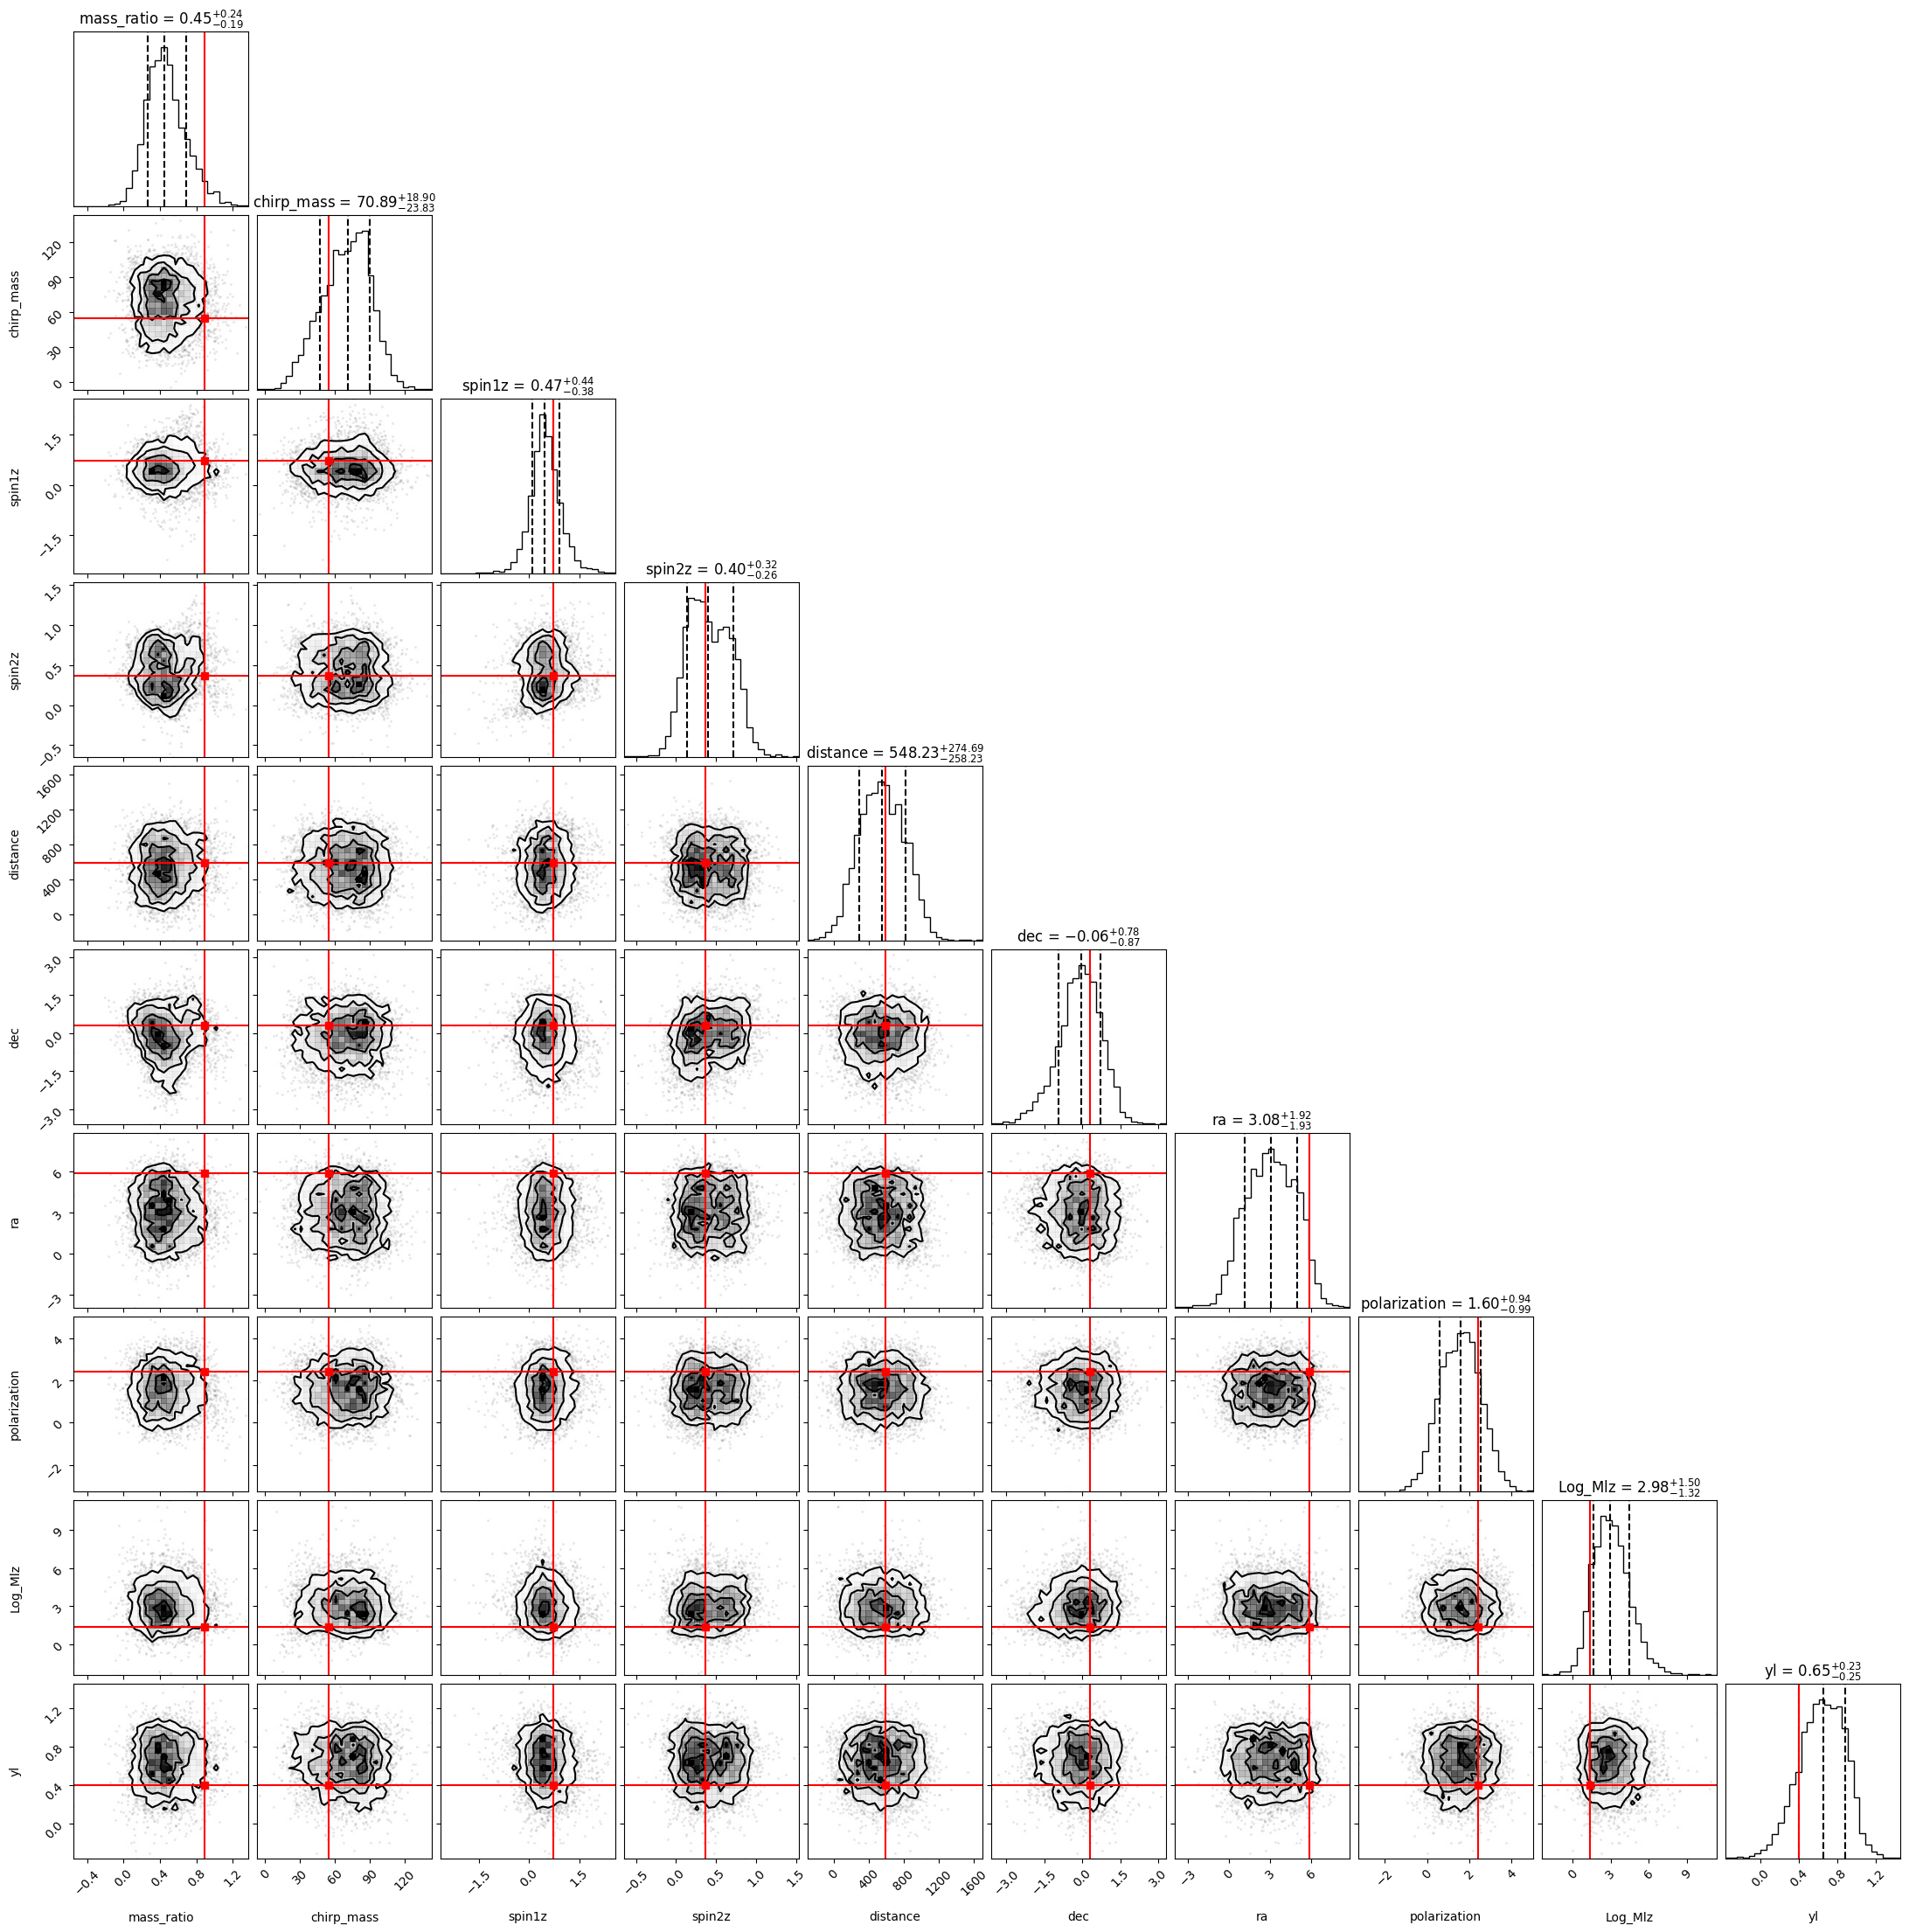

In [20]:
data = posterior_samples.squeeze(0).cpu().numpy() 

figure = corner.corner(
    data,
    bins=30,  # Number of bins
    labels=list(samples[0].keys()),
    quantiles=[0.16, 0.5, 0.84], 
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truths=theta_test.cpu().numpy(),
    truth_color="red",
)

# plt.axvline(x=0, color='k', linestyle='--')
plt.show()

In [21]:
from modules.pp_plot_code import calculate_pp_values, plot_pp_plot, compute_pp_statistics, plot_overlay_pp_plot, plot_individual_pp_plots

Computing P-P values: 100%|██████████| 500/500 [12:30<00:00,  1.50s/it]

Generating overlaid P-P plot...


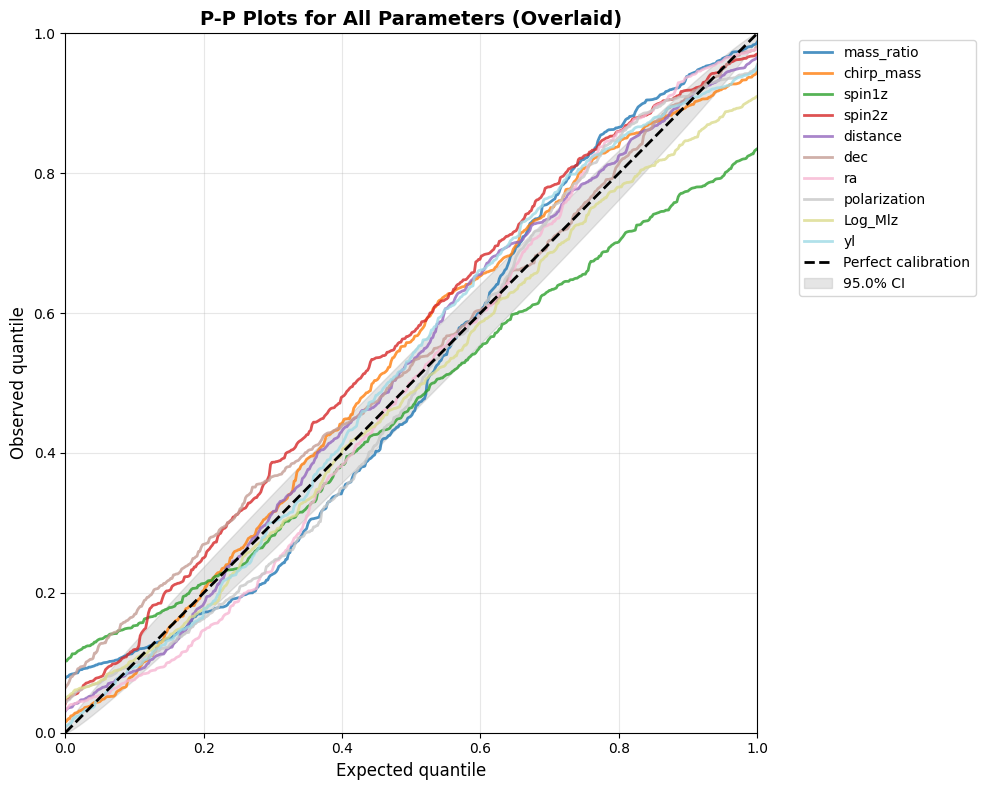

P-P Plot Statistics:

mass_ratio:
  Mean P-value: 0.5037 (should be ~0.5)
  Std P-value: 0.3108 (should be ~0.2887)
  KS test p-value: 0.0020 (>0.05 indicates good calibration)

chirp_mass:
  Mean P-value: 0.5243 (should be ~0.5)
  Std P-value: 0.2941 (should be ~0.2887)
  KS test p-value: 0.0038 (>0.05 indicates good calibration)

spin1z:
  Mean P-value: 0.4616 (should be ~0.5)
  Std P-value: 0.2267 (should be ~0.2887)
  KS test p-value: 0.0000 (>0.05 indicates good calibration)

spin2z:
  Mean P-value: 0.5557 (should be ~0.5)
  Std P-value: 0.2845 (should be ~0.2887)
  KS test p-value: 0.0004 (>0.05 indicates good calibration)

distance:
  Mean P-value: 0.5176 (should be ~0.5)
  Std P-value: 0.2956 (should be ~0.2887)
  KS test p-value: 0.0318 (>0.05 indicates good calibration)

dec:
  Mean P-value: 0.5321 (should be ~0.5)
  Std P-value: 0.2630 (should be ~0.2887)
  KS test p-value: 0.0026 (>0.05 indicates good calibration)

ra:
  Mean P-value: 0.4971 (should be ~0.5)
  Std P-value: 

In [22]:

if __name__ == "__main__":

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # flow.load_state_dict(torch.load('trained_flow_model.pth'))
    
    pp_values, parameter_names = calculate_pp_values(
        flow, test_data_loader, device, num_posterior_samples=5000
    )
    
    print("Generating overlaid P-P plot...")
    plot_overlay_pp_plot(pp_values, parameter_names, confidence_level=0.95)

    compute_pp_statistics(pp_values, parameter_names)
    
    np.save('pp_values.npy', pp_values)
    np.save('parameter_names.npy', parameter_names)
    
    print("\nP-P analysis completed!")